# TESS lightkurve Example Notebook

Set the series of imports you will need. For this the minimum requirement is shown below, but you might find some other python functions that you want to use in the project. Just make sure you import the needed routines.

You can also choose to work in a script and use a terminal - do what is best for you, but **make sure you document everything in your lab books!**

In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook 
#this allows us to easily work in the notebook format

The first thing we imported here was the Lightkurve package. This will form the back bone of this project and it contains many hidden gems in its funtionality. Make sure you have a good read of the documentation - this page has the best information [https://docs.lightkurve.org/reference/index.html](https://docs.lightkurve.org/reference/index.html)

We are now going to use lightkurve imported as simply lk above to find our data based on the TIC numbers and sectors listed in the TESS_Phys301_target_list.txt

The following is an example starting things off for one of the targets. 

**You will need to visually inspect all the targets and select FIVE to examine in detail**

In [3]:
target_identifier = 'TIC ' + '279614617'
sector_number = 9

search_result = lk.search_lightcurve(target_identifier, mission='TESS', sector=sector_number, 
                                     exptime=120, author='SPOC')
lc = search_result.download()
print(lc.keys()) # This will tell you what objects are in the light curve file we have just downloaded
print('---------')
print(lc.meta.keys()) # This will tell you other keys that are contained in the metadat of the file

# We now need to normalize our light curve so we can plot it and examine the target
lc = lc.normalize()

lc = lc.remove_outliers(sigma=10) # clip the light curve to remove deviant datapoints greater than 10 sigma
# You can play around with the sigma value - what does this do to the light curve?
# This also removes nans
print(lc.flux.shape, lc.flux[0:10])

ValueError: ``time_column`` should be provided since the default Table readers are being used.

We can now plot the downloaded data

You can also save each lightcurve figure as a PDF, See if you can automate this for all targets to make you final selection of five to examine in detail for your project.

In [ ]:
fig = plt.figure(figsize=(6,4))
plt.errorbar(lc.time.mjd-lc.time[0].mjd, lc.flux, lc.flux_err, fmt='.', ecolor='LightGrey')
# Note the values are called from the associated lc result we defined above
# x = the time array (in units of MJD) minus the time of the first data point
# y = flux
# err = flux_err 

# Looking through the documentation for Lightkurve we can see it has a binning function
# https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.bin.html#lightkurve.LightCurve.bin
# Let's bin up the light curve and overplot that on the full data
lc_bin = lc.bin(time_bin_size = 0.05) # Default time is in days
plt.errorbar(lc_bin.time.mjd-lc_bin.time[0].mjd, lc_bin.flux, lc_bin.flux_err, fmt='.', ecolor='green')

plt.xlabel('Time[ days]')
plt.ylabel('Normalized Flux')

Zoom in to plot on small section of the light curve with a feature we want to investigate

<IPython.core.display.Javascript object>


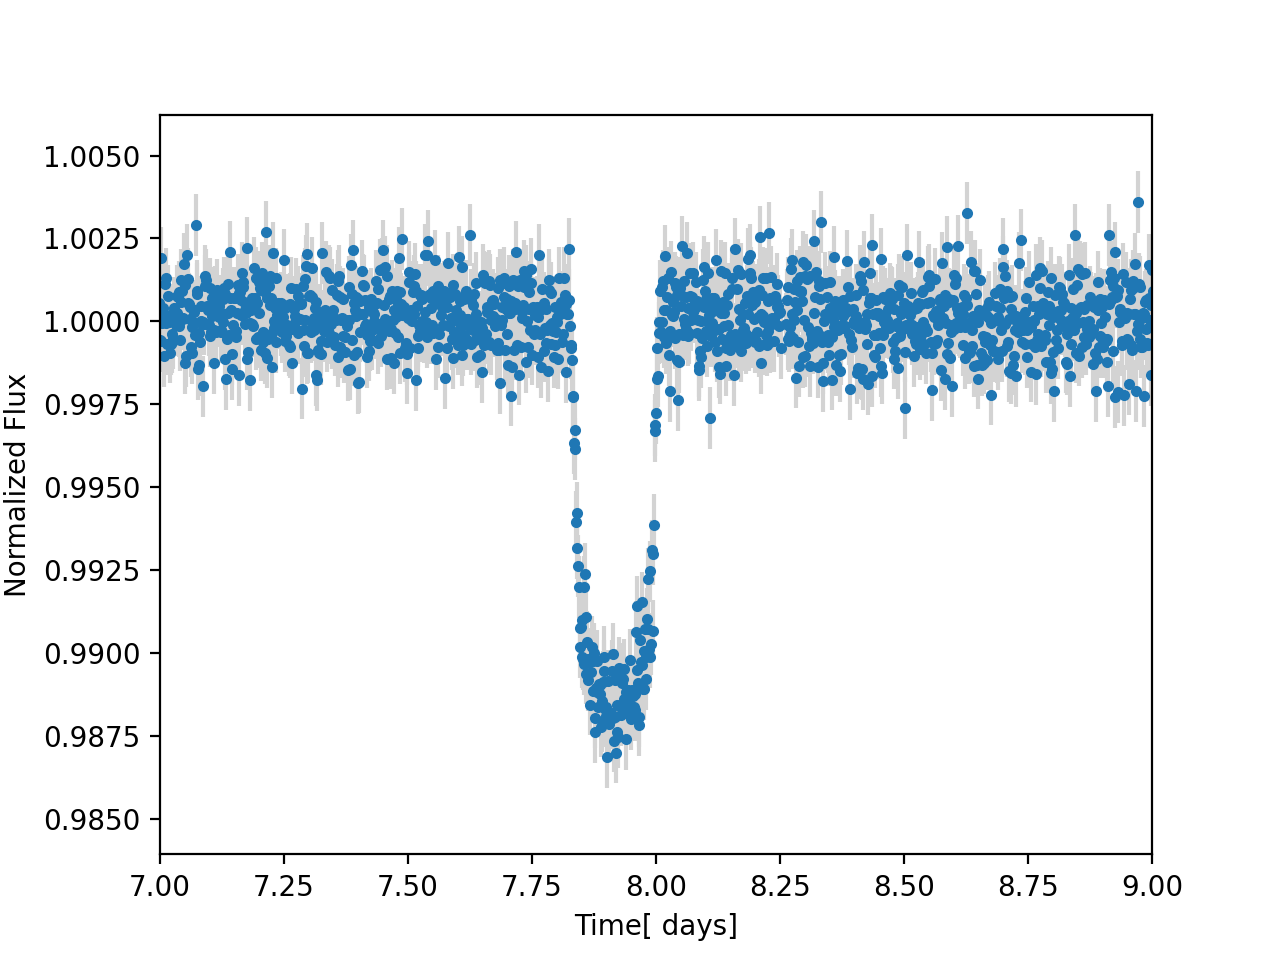

(7.0, 9.0)

In [4]:
fig = plt.figure()
plt.errorbar(lc.time.mjd-lc.time[0].mjd, lc.flux, lc.flux_err, fmt='.', ecolor='LightGrey')
plt.xlabel('Time[ days]')
plt.ylabel('Normalized Flux')
plt.xlim(7.0,9.0) 
#This is a simple manual cut we are doing on the timeseries plot you can also do this in an interactive window

**I think we might have found something!**

## What to look for and measure
Approximate the amplitude and period of the signal. 
   - What is the change in flux. Can you estimate it from the y-axis values?
   - How long does the flux change last for. Zoom in even further in time and approxmate the length of the dimming
   - What is the time period of the changes or between changes. How often does this repeat? Can you get an idea from the full light curve?
   
**What astrophysical phenoenon might this correspond to?**


### Noise Properties
Now let's have a look at the target spectrum and its noise properties
   - How much scatter is there in the measured flux - what is the standard deviation of the measured signal?

In [6]:
print(lc.time.mjd.shape, lc.flux.shape, lc.flux_err.shape) #look at how many points are in your lightcurve
cut = 2000 # Select a range or part of the lighcurve to look at
fig = plt.figure(figsize=(6,4))
plt.plot(lc.time.mjd[0:cut],lc.flux[0:cut])

# We can calculate the standard deviation of the data and compare it to the uncertainty on the flux given
scatter = np.std(lc.flux[0:cut]) 
print('Standard deviation = ', scatter)
print('Mean err = ', np.mean(lc.flux_err))

NameError: name 'lc' is not defined

What does the standard deviation tell us about the data? How does it compare to the mean error on the lightcurve points?

If you bin up the data what do you expect to happen to the mean error? Plot out the value of the mean error as a function of how much you bin the data. 

To improve things you may want to remove any long term variability using the Lightkurve flatten function if the signal is hidden in the noise of the light curve. 

<IPython.core.display.Javascript object>


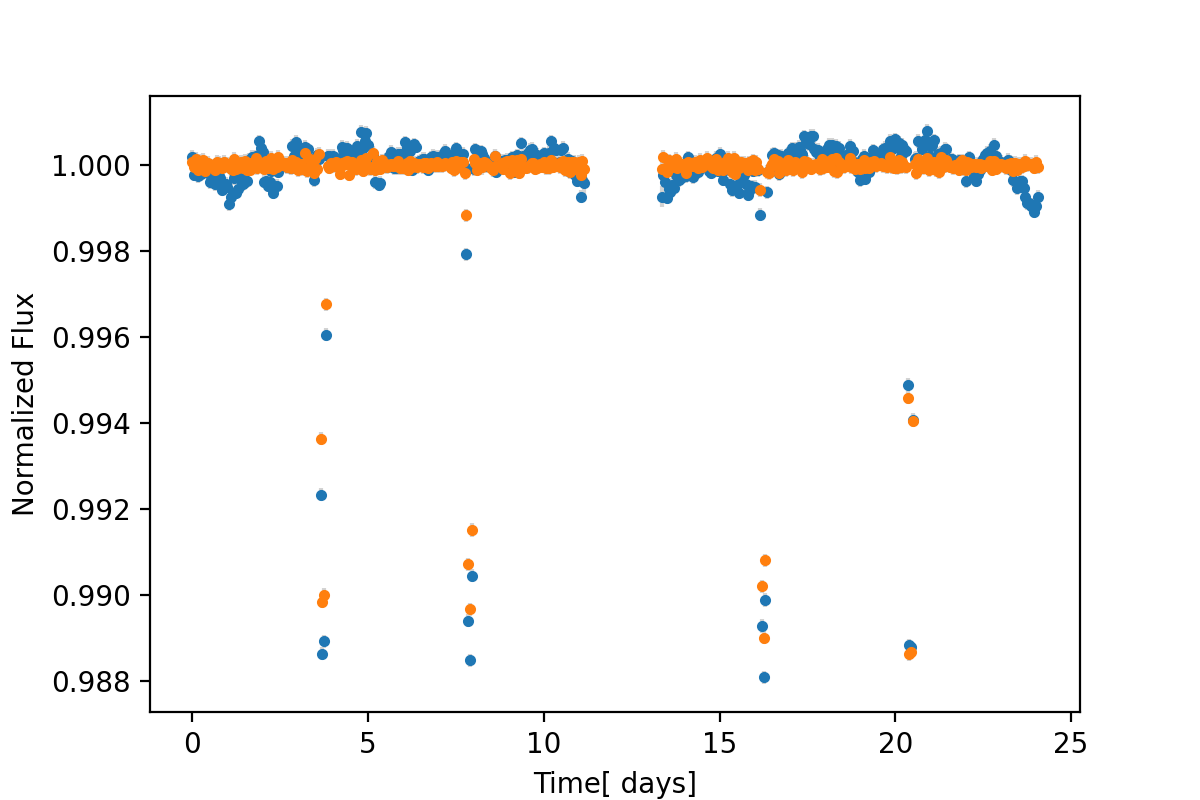

Text(0, 0.5, 'Normalized Flux')

In [6]:
# Let's define a new lightcurve ojbect where we have flattened the light curve
lc_f = lc.flatten()
lc_fbin = lc_f.bin(time_bin_size = 0.05)

# To see this effect better we will bin up the light curves
plt.figure(figsize=(6,4))
plt.errorbar(lc_bin.time.mjd-lc_bin.time[0].mjd, lc_bin.flux, lc_bin.flux_err, fmt='.', ecolor='LightGrey')

plt.errorbar(lc_fbin.time.mjd-lc_fbin.time[0].mjd, lc_fbin.flux, lc_fbin.flux_err, fmt='.', ecolor='LightGrey')

plt.xlabel('Time[ days]')
plt.ylabel('Normalized Flux')

Now what is the standard deviation?

### Finding Repeating Features using a power spectrum
We now want to find a robust way to determine the period of any repeating patterns in the light curve, does this match to what you have estimated.
- Generate a power spectrum from the time series. 
    - You can do this in a number of ways the lightkurve package has three different methods, note these down and explain the difference. 
    - Moving forward we are going to focus on the Box Least Squares Method.
- Plot the power spectrum (also known as a periodogram) and determine the maximum power signal and frequency
- Phase fold the light curve to the maximum frequency. Does a feature that repeats itself now stand out?
- From your phase folded lightcurve determine the amplitude of the flux change. What does this value mean and what astrophysical phenomenon have you found. Compare this to your earlier estimation. How different are they? Recompute the noise of this feature has the phase folding helped improve the signal-to-noise?

### Finding secondary signals in the light curve
If we want to identify additional transit signals, it will be much more convenient if we first remove the previously identified signal. This can be used to search for extra planets in the system, circumbinary planets if our first signal was a star, or to look for stellar variability.

You will first need to start by masking out our candiate planet transit siginal. This requires highlighting the pixels that we think are part of the candidate planet transits. You can make this mask using parameters from your method of finding the power spectrum to identify points associated with that signal.

Plot out the full light curve with the masked values plotted in red to check that you are masking all of the values associated with your identified feature. 

Now the maximum power signal has been removed, search for a repeating signal again using you power spectrum function. 

Repeat the above steps, phase folding the masked light curve on this signal and explaining the astrophysical origins. Perhaps there is not another dominant signal in the light curve. What does this mean? Approximate the activity variation of the target star from the data. 

**If you would prefer to conduct this analysis in another program then you can write out the lightcurve data you plotted to another format, for example a csv or txt file.**

## Extra Functions to play with in Lightkurve
- Lightkurve has an interactive Box Least Squares algorithm that may work for you as well. So let's take a look at the original light curve without the masking (You might need to execute the cell below and then run Cell-->Run all 
- You can also query the MAST database which hosts all of the TESS data (along with a lot of other astrophysical datasets) to look for information on the target star and find its radius. You will need to know this to approximate the size of the planet from the transit depth. For this you will need use the following ```from astroquery.mast import Catalogs```